# Use Customer_Segmentation Notebook Template

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Matplotlib created a temporary cache directory at /tmp/matplotlib-49ms63jb because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Read data from Snowflake CUSTOMER_TRANSACTION_MASTER using fosforio sdk

In [2]:
from fosforio import snowflake

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


In [3]:
# To get snowflake connection object with a default snowflake connection created by the user, if available.
#snowflake.get_connection()

# To get snowflake connection object with a specific connection name
snowflake.get_connection(connection_name="FDC_Insurance_Snowflake")

Exception occurred in getting snowflake connection: 'connectionSources'


In [4]:
# To read a specific dataset published from a snowflake connection
df = snowflake.get_dataframe("CUSTOMER_TRANSACTION_MASTER")

In [5]:
df_original = df.copy()

In [6]:
df.shape

(122882, 27)

In [7]:
df.tail()

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
122877,3a7ce3d5-0f4b-4575-badc-3553f5440c92,2023-05-01,32,MALE,High School,Unemployed,reading,Single,One Dependent,2020-03-12,...,684.4068,305.7313,339.07230,Very high,Low,Very high,21.20,273.352691,242.288921,0.0
122878,e2a8f308-57eb-4f55-bc13-399378f246d3,2022-12-01,27,MALE,PhD,Unemployed,camping,Single,One Dependent,2009-05-12,...,535.0963,0.0000,482.58685,Very high,Very low,Very high,25.92,474.722440,165.534652,0.0
122879,599c0e61-9bbc-4e14-bbfd-b07f5a398669,2022-12-01,33,FEMALE,High School,Unemployed,video-games,Single,One Dependent,2007-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,568.542708,549.300475,0.0
122880,77298902-f899-4c3e-9104-06d1736fb089,2023-06-01,33,FEMALE,College,Unemployed,basketball,Single,One Dependent,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,517.588408,544.214360,0.0
122881,cd75294e-c31f-41b3-b78c-1d3e7322ddcf,2022-12-01,44,FEMALE,High School,Employed,exercise,Married,Two Dependents,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,1029.696570,1552.899035,0.0


In [8]:
to_drop = ['CUSTOMER_ID','DATE','AGE','SEX','EDUCATION_LEVEL','EMPLOYMENT_STATUS','HOBBIES','MARITAL_STATUS','BANK_ACCOUNT_TYPE',
 'DEPENDENTS','REGISTRATION_DATE','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY','BALANCE_FREQUENCY']

In [9]:
df.drop(to_drop, axis= 1, inplace= True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122882 entries, 0 to 122881
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BALANCE                 122882 non-null  float64
 1   CREDIT_LIMIT            122882 non-null  float64
 2   CASH_ADVANCE            122882 non-null  float64
 3   CASH_ADVANCE_FREQUENCY  122882 non-null  float64
 4   CASH_ADVANCE_TRX        122882 non-null  float64
 5   PURCHASES               122882 non-null  float64
 6   ONEOFF_PURCHASES        122882 non-null  float64
 7   INSTALLMENTS_PURCHASES  122882 non-null  float64
 8   PURCHASES_TRX           122882 non-null  float64
 9   PAYMENTS                122882 non-null  float64
 10  MINIMUM_PAYMENTS        122882 non-null  float64
 11  PRC_FULL_PAYMENT        122882 non-null  float64
dtypes: float64(12)
memory usage: 11.3 MB


In [11]:
scalar=StandardScaler()
scaled_df = scalar.fit_transform(df)

In [12]:
scaled_df.shape

(122882, 12)

### PCA

In [13]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,0.197136,1.814406
1,-0.316559,-0.338030
2,-0.396128,-0.378987
3,-0.376358,-0.278053
4,-0.267530,-0.292796
...,...,...
122877,-0.799041,-0.826553
122878,-0.906897,-0.968390
122879,-1.173773,0.945230
122880,-1.194497,0.964048


In [14]:
k= range(2,6)
inertia_values= []
silhoutte_scores= []

for i in k:
    print(f'Trying KMean clusttering for k= {i}')
    kmean= KMeans(n_clusters= i, random_state= 42)
    kmean.fit(pca_df)
    inertia_values.append(kmean.inertia_)
    
    sil_score= silhouette_score(pca_df, kmean.labels_)
    silhoutte_scores.append(sil_score)

Trying KMean clusttering for k= 2


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 3


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 4


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Trying KMean clusttering for k= 5


/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-15-014eb2e75c29>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


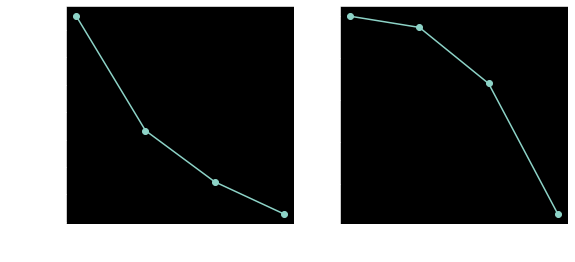

In [15]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(9,4))
    plt.title("Elbow Method")

    plt.subplot(1,2,1)
    plt.plot(k, inertia_values, marker= 'o', linestyle= '-')
    plt.xlabel("No of clusters (K)")
    plt.ylabel("Inertia")

    plt.subplot(1,2,2)
    plt.plot(k, silhoutte_scores, marker= 'o', linestyle= '-')
    plt.xlabel("No of clusters (K)")
    plt.ylabel("Silhouette Score")

    plt.show()

In [16]:
k= 4
kmean= KMeans(n_clusters=k, random_state= 42)
kmean.fit(pca_df)

/tmp/pip_packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [17]:
pca_df['Group']= kmean.labels_

In [18]:
pca_df.columns= ['PC1','PC2','Group']

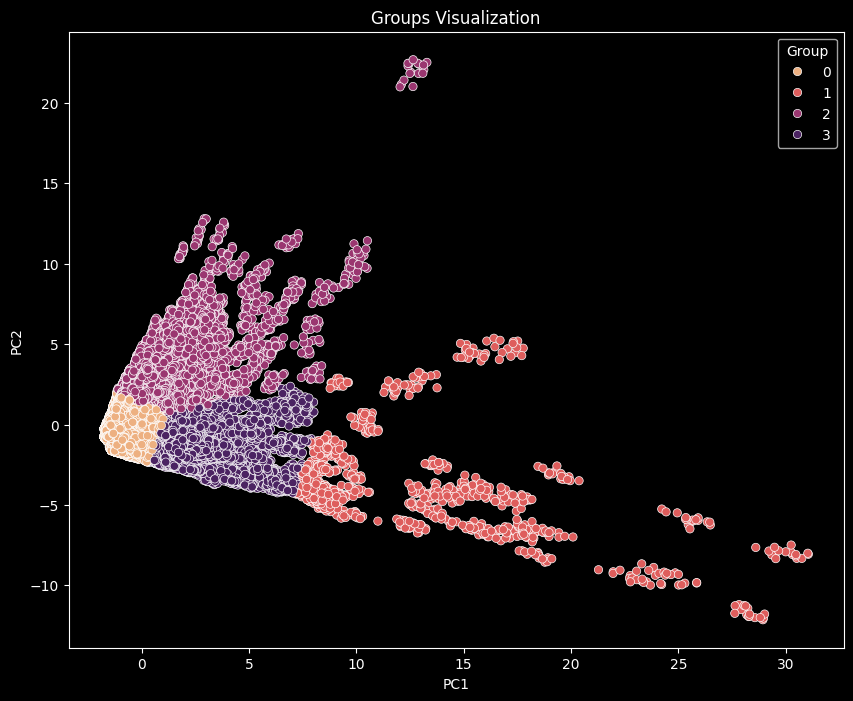

In [19]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(10,8))
    sns.scatterplot(x="PC1",y="PC2",hue="Group",data=pca_df,palette='flare')
    plt.title("Groups Visualization")
    plt.show()

In [20]:
pca_df['Group'].value_counts()

Group
0    85997
2    20461
3    15362
1     1062
Name: count, dtype: int64

In [21]:
cluster_centers = pd.DataFrame(data=kmean.cluster_centers_,columns=['PC1','PC2'])

In [22]:
cluster_centers

,PC1,PC2
0,-0.793861,-0.405865
1,12.722399,-3.938086
2,0.953669,2.978182
3,2.286775,-1.417736


In [23]:
cluster_df = pd.concat([df_original,pd.DataFrame({'Cluster':kmean.labels_})],axis=1)

In [24]:
cluster_df.head()

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
0,PNC32940ed8-682f-4052-92b2-cfdc7f41e,2023-12-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2004-11-12,...,0.00000,0.0,Very low,Very low,Very low,0.000,3774.789989,1007.999804,0.214444,2
1,PNCe415caf5-6212-4f50-a062-c12bf1eea,2024-01-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2023-07-12,...,819.56020,0.0,Very high,Very high,Very low,11.400,665.611414,589.647700,0.000000,0
2,PNC1ef5b665-11ae-40d7-b364-be8fa02b9,2023-02-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2021-11-12,...,746.10905,0.0,Very high,Very high,Very low,10.920,653.170079,570.829156,0.000000,0
3,PNC436a6069-0e61-47f2-96e8-d11c19e4b,2024-04-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2019-07-12,...,1603.93000,0.0,Very low,Very low,Very low,0.965,0.000000,0.000000,0.000000,0
4,PNCaaa1c8bb-7289-4c25-a05e-efe26e316,2024-02-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2022-09-12,...,1588.94000,0.0,Very low,Very low,Very low,1.060,0.000000,0.000000,0.000000,0


In [25]:
cluster_1_df = cluster_df[cluster_df["Cluster"]==0]
cluster_1_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
1,PNCe415caf5-6212-4f50-a062-c12bf1eea,2024-01-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2023-07-12,...,819.56020,0.00000,Very high,Very high,Very low,11.400,665.611414,589.647700,0.0,0
2,PNC1ef5b665-11ae-40d7-b364-be8fa02b9,2023-02-01,34,MALE,Undisclosed,Unemployed,Undisclosed,Married,No Dependents,2021-11-12,...,746.10905,0.00000,Very high,Very high,Very low,10.920,653.170079,570.829156,0.0,0
3,PNC436a6069-0e61-47f2-96e8-d11c19e4b,2024-04-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2019-07-12,...,1603.93000,0.00000,Very low,Very low,Very low,0.965,0.000000,0.000000,0.0,0
4,PNCaaa1c8bb-7289-4c25-a05e-efe26e316,2024-02-01,29,MALE,Undisclosed,Unemployed,Undisclosed,Single,One Dependent,2022-09-12,...,1588.94000,0.00000,Very low,Very low,Very low,1.060,0.000000,0.000000,0.0,0
5,PNCcf3bca5a-b756-486c-882c-dd005b48e,2022-08-01,21,MALE,Undisclosed,Unemployed,Undisclosed,Single,No Dependents,2021-06-12,...,16.80000,0.00000,Very low,Very low,Very low,0.965,617.284634,227.655850,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122876,90f9a2e5-d25f-4dcb-9a2d-b8608f760455,2022-11-01,32,FEMALE,JD,Unemployed,hiking,Single,One Dependent,2002-08-12,...,305.73130,291.53880,Very high,Average,High,18.800,270.797993,220.049841,0.0,0
122877,3a7ce3d5-0f4b-4575-badc-3553f5440c92,2023-05-01,32,MALE,High School,Unemployed,reading,Single,One Dependent,2020-03-12,...,305.73130,339.07230,Very high,Low,Very high,21.200,273.352691,242.288921,0.0,0
122878,e2a8f308-57eb-4f55-bc13-399378f246d3,2022-12-01,27,MALE,PhD,Unemployed,camping,Single,One Dependent,2009-05-12,...,0.00000,482.58685,Very high,Very low,Very high,25.920,474.722440,165.534652,0.0,0
122879,599c0e61-9bbc-4e14-bbfd-b07f5a398669,2022-12-01,33,FEMALE,High School,Unemployed,video-games,Single,One Dependent,2007-02-12,...,0.00000,0.00000,Very low,Very low,Very low,0.000,568.542708,549.300475,0.0,0


In [26]:
cluster_2_df = cluster_df[cluster_df["Cluster"]==1]
cluster_2_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
175,PNCadb3e0be-ba25-41f4-bb1b-4d4029a63,2024-03-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2015-09-12,...,6587.0928,4784.0924,Very high,High,Very high,137.41,11154.808880,8006.223162,0.00000,1
379,PNC6bf27308-7ad9-4cc2-bca2-9c2a858aa,2024-03-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2011-10-12,...,6648.0844,5445.7222,Very high,High,Very high,141.94,11154.808880,8815.362737,0.00000,1
383,PNC34ee0418-8d5f-49ec-b653-55d90625a,2024-04-01,64,MALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2020-01-12,...,8700.4800,2508.4750,Very high,High,Very high,129.15,8952.529720,3130.044809,0.00000,1
410,PNCc19e322c-2530-4475-9778-c46b5d3af,2024-04-01,70,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2003-02-12,...,6648.0844,4911.3289,Very high,High,Very high,160.06,11154.808880,8943.121617,0.00000,1
555,PNCa0b1e136-f47a-492e-ad3a-8638c3c01,2023-08-01,62,MALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2017-03-12,...,12462.4400,0.0000,Very high,Very high,Very low,217.00,11628.715570,2000.990921,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120133,780b903b-df24-48ce-a1e8-df34e5d0368c,2024-04-01,69,MALE,MD,Retired,video-games,Widowed,No Dependents,1998-06-12,...,7322.2432,3684.1326,Very high,Very high,Average,110.21,12438.133302,166.084574,0.63000,1
122131,dc88d8d8-5177-48a5-b94a-4a7910a0f6a1,2023-01-01,55,FEMALE,College,Employed,kayaking,Married,No Dependents,2016-11-12,...,25188.6040,254.0820,Average,Average,Very low,35.31,31080.030484,12802.099820,0.72375,1
122132,022af4e7-259f-426a-b3cf-a5dedc0489d4,2022-04-01,55,MALE,Masters,Employed,paintball,Married,No Dependents,2021-05-12,...,28900.6088,289.2210,Average,Average,Very low,34.65,32431.336157,12802.099820,0.69750,1
122133,41dbbd7e-2e94-40ab-8c3a-866481f51690,2022-07-01,55,MALE,Masters,Employed,reading,Married,No Dependents,2021-10-12,...,25586.3188,254.0820,High,Average,Very low,30.69,32131.046007,12683.561859,0.79500,1


In [27]:
cluster_3_df = cluster_df[cluster_df["Cluster"]==2]
cluster_3_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
0,PNC32940ed8-682f-4052-92b2-cfdc7f41e,2023-12-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2004-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3774.789989,1007.999804,0.214444,2
14,PNCa15f21bc-df48-4d16-a5b7-23df94fa8,2022-10-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2022-09-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3774.789989,997.276402,0.204444,2
16,PNC33c4a97f-d846-48ba-b79b-89baf176e,2023-06-01,49,FEMALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2013-12-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3897.880967,1109.872125,0.206666,2
19,PNC17422881-4f07-4c03-8409-fc8497639,2023-05-01,49,MALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,1999-05-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,3815.820315,1109.872125,0.204444,2
34,PNC70cee698-e367-4e58-a695-04e0bb35c,2023-05-01,49,MALE,Undisclosed,Employed,Undisclosed,Married,Two Dependents,2014-06-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,4308.184227,1168.850837,0.235555,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122853,d3e5d939-04fa-4cfe-81ee-4ecff3248b52,2024-04-01,44,MALE,High School,Employed,cross-fit,Married,Two Dependents,2008-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,1121.827315,1509.762951,0.000000,2
122854,4f6fb9d4-be51-4fc1-9bcf-386a9b4fb9f0,2022-06-01,44,MALE,Associate,Employed,base-jumping,Married,Two Dependents,2022-08-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,986.340925,1538.520340,0.000000,2
122855,5d22b285-bcb9-4daa-b961-c7843bad75f8,2022-05-01,44,FEMALE,PhD,Employed,chess,Married,Two Dependents,2016-11-12,...,0.0000,0.0,Very low,Very low,Very low,0.00,1018.857658,1509.762951,0.000000,2
122857,8e33d093-7672-4f21-9e76-03e75a8c074e,2022-05-01,52,FEMALE,Associate,Self-Employed,reading,Married,Three or More Dependents,2005-05-12,...,79.8735,1476.6,Low,Very low,Low,7.36,6448.450204,1932.687351,0.000000,2


In [28]:
cluster_4_df = cluster_df[cluster_df["Cluster"] == 3]
cluster_4_df

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
10,PNCa3755563-44e5-4e81-9e6a-fc6ff0da9,2024-04-01,67,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2018-05-12,...,6722.76150,626.4258,Very high,Very high,Very high,59.520,6862.659474,204.998200,1.00000,3
26,PNCb39f76c8-4554-4f8c-8075-574daec81,2024-05-01,49,FEMALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2015-04-12,...,2625.24150,653.1616,Very high,Low,Very high,26.910,638.676873,446.088382,0.26750,3
28,PNCe0fcf2b9-0402-416e-9b05-3ef66270c,2022-04-01,67,FEMALE,Undisclosed,Retired,Undisclosed,Widowed,No Dependents,2003-03-12,...,6082.49850,633.3096,Very high,Very high,Very high,61.760,5782.426038,186.181940,1.00000,3
54,PNC3c95c9c9-efed-44d2-9af6-5e8acada5,2023-03-01,36,MALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2021-06-12,...,394.76240,1855.4076,High,Very low,High,24.700,1713.847635,268.717645,0.09000,3
55,PNCa981082e-046f-41d4-890e-61035dbdf,2023-11-01,36,MALE,Undisclosed,Unemployed,Undisclosed,Single,Two Dependents,2019-04-12,...,405.26140,1821.0482,Very high,Very low,High,27.560,1738.686007,271.229025,0.08625,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122757,35aae655-5111-41cc-bdda-f57e0685ee23,2022-09-01,36,FEMALE,Masters,Unemployed,board-games,Single,Two Dependents,2018-09-12,...,2103.34750,2154.8100,Very high,Very high,Very high,69.345,4128.273225,171.600284,0.00000,3
122758,e2dabec5-6d12-49fb-a843-31225fbfb500,2023-06-01,36,FEMALE,High School,Unemployed,yachting,Single,Two Dependents,2009-09-12,...,2136.55825,1980.3730,Very high,Very high,Very high,62.980,4051.823720,198.000328,0.00000,3
122784,cefe5ad0-b9e2-4e2b-9bb2-d74caf9d6562,2022-12-01,43,MALE,Masters,Unemployed,sleeping,Single,Two Dependents,2019-09-12,...,2333.93880,1273.0432,Very high,Very high,Very high,68.080,4766.566222,219.075443,0.00000,3
122795,e1f9206a-d67e-4ba8-a47f-41101e06eb29,2022-11-01,50,MALE,College,Unemployed,dancing,Single,No Dependents,2022-03-12,...,0.00000,2361.5572,Very high,Very low,Very high,37.720,2781.542766,153.226966,1.00000,3


<Axes: xlabel='Cluster', ylabel='count'>

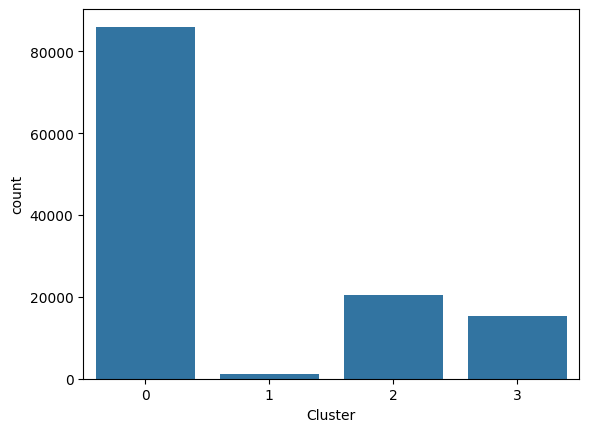

In [29]:
sns.countplot(x='Cluster', data=cluster_df)

In [31]:
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85997 entries, 1 to 122880
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUSTOMER_ID                       85997 non-null  object 
 1   DATE                              85997 non-null  object 
 2   AGE                               85997 non-null  int8   
 3   SEX                               85997 non-null  object 
 4   EDUCATION_LEVEL                   85997 non-null  object 
 5   EMPLOYMENT_STATUS                 85997 non-null  object 
 6   HOBBIES                           85997 non-null  object 
 7   MARITAL_STATUS                    85997 non-null  object 
 8   DEPENDENTS                        85997 non-null  object 
 9   REGISTRATION_DATE                 85997 non-null  object 
 10  BANK_ACCOUNT_TYPE                 85997 non-null  object 
 11  BALANCE                           85997 non-null  float64
 12  BALANCE_

In [32]:
cluster_1_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.000000,85997.0
mean,28.488424,981.036725,3739.682801,392.453105,0.077286,1.383431,523.649385,287.896728,236.064047,9.067885,980.979823,546.462819,0.136226,0.0
std,7.288076,1120.294068,2818.883535,755.003071,0.116443,2.342937,602.308363,488.171216,365.180698,10.500832,1100.289447,1225.624275,0.271976,0.0
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,23.000000,81.492922,1590.000000,0.000000,0.000000,0.000000,41.340000,0.000000,0.000000,0.940000,332.383968,149.032733,0.000000,0.0
50%,28.000000,645.237809,2820.000000,0.000000,0.000000,0.000000,308.962500,11.060000,53.010000,6.210000,647.368140,235.851019,0.000000,0.0
75%,32.000000,1472.581155,5250.000000,432.940060,0.130000,2.000000,809.497800,390.550000,352.716200,12.840000,1243.859097,560.582930,0.103500,0.0
max,70.000000,8683.091745,24840.000000,8447.199333,0.750556,21.800000,3941.816400,3978.314700,2585.392800,107.115000,15368.273078,27486.340911,1.000000,0.0


In [33]:
cluster_2_df.describe(include=['int8','int32','float64'])

,AGE,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.0
mean,61.324859,5062.305961,13483.996234,1147.369176,0.070039,2.613828,17844.426400,11705.463495,6030.274753,144.184101,17702.567360,3990.130234,0.388355,1.0
std,6.041712,4109.389766,5338.927049,3647.005851,0.190664,8.439337,9424.255917,10016.158469,4514.072021,85.985219,10271.543949,9887.888387,0.409753,0.0
min,51.000000,323.958220,2576.000000,0.000000,0.000000,0.000000,7042.926800,0.000000,0.000000,2.760000,2446.486783,144.148875,0.000000,1.0
25%,55.000000,1934.647886,9315.000000,0.000000,0.000000,0.000000,10812.944850,3774.734175,2944.375863,81.765000,10091.078820,465.977841,0.000000,1.0
50%,62.000000,3280.011015,13195.000000,0.000000,0.000000,0.000000,13621.419600,9635.962700,5204.072600,134.820000,14505.557409,1121.449168,0.175834,1.0
75%,66.000000,7840.130694,17000.000000,0.000000,0.000000,0.000000,23501.068500,17618.018400,8410.746300,201.770000,24166.958488,2813.434786,0.861667,1.0
max,70.000000,19043.138560,30240.000000,21269.687565,1.090000,52.320000,49039.570000,43873.984800,22500.000000,378.230000,51154.352082,76406.207520,1.000000,1.0


In [ ]:
cluster_1_df.describe(include=['int8','int32','float64'])

In [44]:
cluster_df.to_csv("/data/Output/kmeans_clustered_customer_Data.csv")

In [45]:
import sys
sys.getsizeof(kmean)

48

In [46]:
#Saving Scikitlearn models
import joblib
joblib.dump(kmean, "/data/Output/kmeans_model.pkl")

['/data/Output/kmeans_model.pkl']